In [1]:
# wind ekman transport and pumping
import glob
import os
import numpy as np
import xarray as xr
import numpy.ma as ma


[xmin,xmax,ymin,ymax]=[334,350,10,30]
[tmin,tmax]=["1993","2022"]
ds = xr.open_mfdataset('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_forcing_m_1980_2023_0.25.nc')
ds['lon'] = (ds['lon'] + 360) % 360
ds = ds.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax),time=slice(tmin,tmax)).groupby('time.season').mean(dim='time')
season_order = ['DJF', 'MAM', 'JJA', 'SON']
ds = ds.sel(season=season_order)
u=ds['tx_sur'].values
v=ds['ty_sur'].values

lon=ds['lon'].values
lat=ds['lat'].values

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

curlc = np.zeros_like(u)
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(u)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    curlc[:,j,:] = (np.gradient(v[:, j, :], x_j, axis=-1) - np.gradient(u[:,j,:], dy, axis=1))

npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
latc = npz["latc"]
latitudes = np.mean(latc, axis=1)  
npz = np.load('fesom_core2_fjra_ekman_m_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
last_slice = npz["etransport"][:, :, 0] * 86400             
etransport = np.broadcast_to(last_slice[..., None],          
                             npz["etransport"].shape)
epumping = npz["epumping"]*86400
etransportm=np.mean(etransport.reshape(int(etransport.shape[0]/12),12,etransport.shape[1],etransport.shape[2]), axis=0)
epumpingm=np.mean(epumping.reshape(int(etransport.shape[0]/12),12,etransport.shape[1],etransport.shape[2]), axis=0)



Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_ekman_m_1993_2022.npz' with keys: windspeed, etransport, epumping, coast, lonc...)


/tmp/ipykernel_1882414/2477392902.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


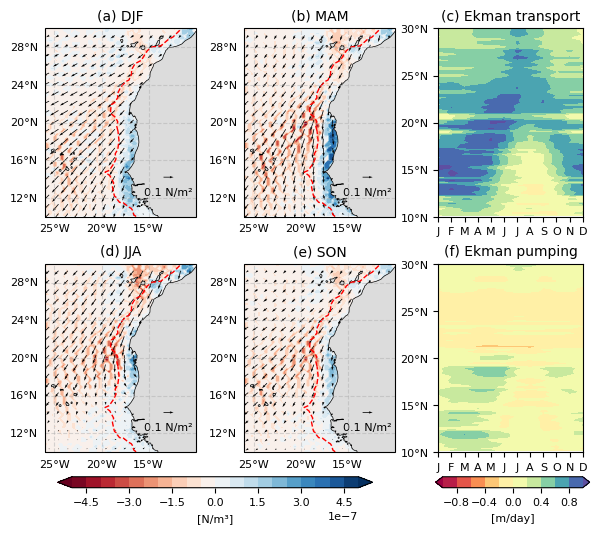

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader, natural_earth
from shapely.geometry import LineString

# Titles
season_titles = ['(a) DJF', '(b) MAM', '(d) JJA', '(e) SON']
hov_labels = ['(c) Ekman transport', '(f) Ekman pumping']
skip = 4
LON, LAT = np.meshgrid(lon, lat)

# 创建 figure 和 gridspec
fig = plt.figure(figsize=(7, 5.5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, .9], wspace=0.25, hspace=0.25)
plt.rcParams.update({
    "font.size": 8,
})

# --- 左侧 4 个地图图层 ---
geo_axes = [plt.subplot(gs[0, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[0, 1], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())]

contour_geo = []
for i, ax in enumerate(geo_axes):
    # WSC
    contour = ax.contourf(
        lon, lat, curlc[i],
        levels=np.linspace(-5e-7, 5e-7, 21),
        cmap='RdBu',
        extend='both',
        transform=ccrs.PlateCarree()
    )
    contour_geo.append(contour)

    # Vector
    bg=1
    quiver = ax.quiver(
        LON[bg::skip, bg::skip], LAT[bg::skip, bg::skip],
        u[i, bg::skip, bg::skip], v[i, bg::skip, bg::skip],
        transform=ccrs.PlateCarree(),
        scale=1.5,
        color="black",
        width=0.005
    )

    ax.quiverkey(quiver, X=0.82, Y=0.21, U=0.1,
             label='0.1 N/m²', labelpos='S',
             coordinates='axes',zorder=1)

    ax.coastlines(linewidth=0.5)
    shapefile_path = natural_earth(category='physical', name='coastline', resolution='110m')
    reader = Reader(shapefile_path)
    for record in reader.records():
        geometry = record.geometry
        if isinstance(geometry, LineString) and geometry.length > 10.0:
            coords = [
                (x, y) for x, y in geometry.coords
                if xmin-360 <= x <= xmax-360+1 and ymin <= y <= ymax+1
            ]
            if coords:
                lons, lats = zip(*coords)
                ax.plot([lon - 2 for lon in lons], lats, transform=ccrs.PlateCarree(),
                        color='red', linestyle='--', linewidth=1)
                # ax.plot([lon - 4 for lon in lons], lats, transform=ccrs.PlateCarree(),
                #         color='blue', linestyle='--', linewidth=1)
    ax.set_extent([xmin-360, xmax-360, ymin, ymax], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=1)
    ax.set_title(season_titles[i], fontsize=10)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle="--", alpha=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {"fontsize": 8}
    gl.xlocator = mticker.MultipleLocator(5)
    gl.ylocator = mticker.MultipleLocator(4)

# Colorbar for maps
cbar_ax1 = fig.add_axes([0.15, 0.045, 0.45, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(contour_geo[0], cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('[N/m³]', fontsize=8)

# --- 右侧 2 个 hovmöller 图 ---
lat_min, lat_max = 10, 30
lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
latitudes_subset = latitudes[lat_mask]

datasets = [etransportm, epumpingm]
cl = [1, 1]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
hov_axes = [plt.subplot(gs[0, 2]), plt.subplot(gs[1, 2])]
contour_hov = []

for i, ax in enumerate(hov_axes):
    hov_data = np.nanmean(datasets[i], axis=-1)
    hov_data_subset = hov_data[:, lat_mask]

    levels = np.linspace(-cl[i], cl[i], 11)
    c = ax.contourf(np.arange(12), latitudes_subset, hov_data_subset.T, levels=levels,
                    cmap='Spectral', extend='both')
    contour_hov.append(c)

    ax.set_title(hov_labels[i], fontsize=10)
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(month_labels, fontsize=8)
    ax.set_ylim(lat_min, lat_max)
    ax.set_yticks(np.arange(lat_min, lat_max+1, 5))
    ax.set_yticklabels([f'{int(l)}°N' for l in np.arange(lat_min, lat_max+1, 5)], fontsize=8)

# Colorbar for hovmöller
cbar_ax2 = fig.add_axes([0.69, 0.045, 0.22, 0.02])  # [left, bottom, width, height]
cbar2 = fig.colorbar(contour_hov[0], cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('[m/day]', fontsize=8)

plt.tight_layout()
plt.savefig("fig5.png", dpi=300, bbox_inches='tight')
plt.show()
